# Template for coursework - Part 1 Classification

In [104]:
# import of libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



## Team identification

* seminar day and time
ST 9:15
* team number
Team D
* names of team members
Michal Červinka, Filip Dvořák, Tomáš Jareš, Dominik Šimon

# Introduction

1.	Describe the business value of addressing this problem with machine learning.

    Použití strojového učení na dataset diabetu může výrazně přispět k zlepšení zdravotní péče. Umožňuje časnou detekci a diagnostiku diabetu, vytváření personalizovaných léčebných plánů, předpovídání pravděpodobnosti komplikací, stratifikaci pacientů na základě rizika a efektivní řízení a sledování nemoci. Tímto způsobem může strojové učení zlepšit klinické 
    rozhodování, výsledky pacientů a přispět k efektivnějšímu poskytování zdravotní péče.

2.	Provide the link to the source of the data.
    https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

## Customization

//TODO

1.	What is the *target attribute*
2.	What is the *instance of interest*   The instance can be identified, for example, by an id.
3.	Choose an *attribute of interest* 
5.	Show *Cost matrix* consisting of a cost of a false positive, false negative, true positive and true negative. Note that cost of true positive and true negative is recommended to be zero.

# Data Exploration

1. Describe meaning of individual attributes
2.	Show a histogram (or a table with value frequencies) for the target variable and for selected other variables. Try to convey the distributions of target variable for each predictor (e.g. by using stacked bar chart) 
3.	Show a scatterplot (correlation plot) showing the relation between selected predictors and the target variable
4.	Interpret the results


## Načtení datasetu


In [105]:
data = pd.read_csv("diabetes_prediction_dataset.csv")
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


## Data exploration

### Četnosti cílové proměnné

Text(0.5, 1.0, 'Cílová proměnná má_diabetes')

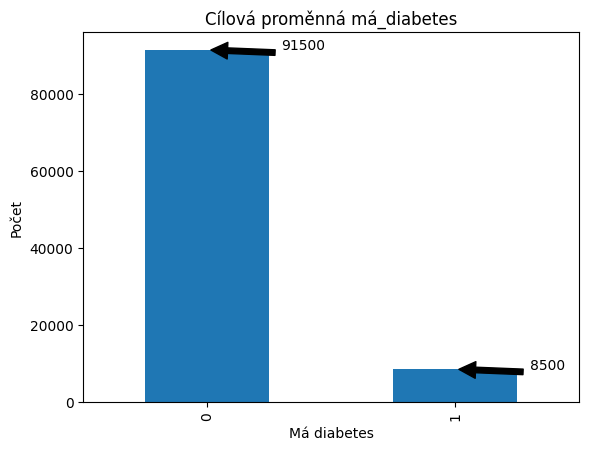

In [106]:
import matplotlib.pyplot as plt
#bar plot X axis = diabetes classes Y axis = count
data.groupby('diabetes').size().plot(kind='bar')
plt.xlabel('Má diabetes')
plt.ylabel('Počet')
count_diabetes_0 = data[data['diabetes'] == 0].shape[0]
count_diabetes_1 = data[data['diabetes'] == 1].shape[0]
plt.annotate(count_diabetes_0,xy=(0, count_diabetes_0),xytext=(0.3, count_diabetes_0),arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(count_diabetes_1,xy=(1, count_diabetes_1),xytext=(1.3, count_diabetes_1),arrowprops=dict(facecolor='black', shrink=0.05))
plt.title("Cílová proměnná má_diabetes")




Cílová proměnná je v datasetu nevyvážená. Budeme muset provést oversampling.

#### Histogramy ostatních proměnných

Never:  35095 35.095 %
No Info:  35816 35.815999999999995 %
Current:  9286 9.286 %
Former:  9352 9.352 %
Ever:  4004 4.004 %
Not current:  6447 6.447 %


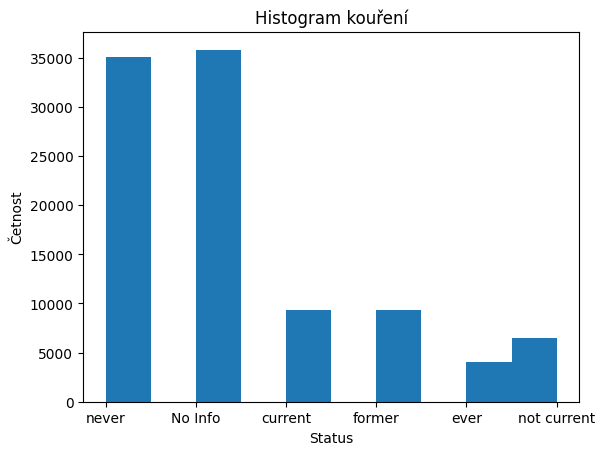

In [107]:
plt.hist(data['smoking_history'])
plt.title("Histogram kouření")
plt.xlabel("Status")
plt.ylabel("Četnost")
print("Never: ",data[data["smoking_history"] == "never"].shape[0], data[data["smoking_history"] == "never"].shape[0]/data.shape[0]*100,"%")
print("No Info: ",data[data["smoking_history"] == "No Info"].shape[0] , data[data["smoking_history"] == "No Info"].shape[0]/data.shape[0]*100,"%")
print("Current: ",data[data["smoking_history"] == "current"].shape[0], data[data["smoking_history"] == "current"].shape[0]/data.shape[0]*100,"%")
print("Former: ",data[data["smoking_history"] == "former"].shape[0], data[data["smoking_history"] == "former"].shape[0]/data.shape[0]*100,"%")
print("Ever: " ,data[data["smoking_history"] == "ever"].shape[0], data[data["smoking_history"] == "ever"].shape[0]/data.shape[0]*100,"%")
print("Not current: ", data[data["smoking_history"] == "not current"].shape[0], data[data["smoking_history"] == "not current"].shape[0]/data.shape[0]*100,"%")

Dataset obsahuje spoustu prázdných hodnot {No info}

Text(0, 0.5, 'Četnost')

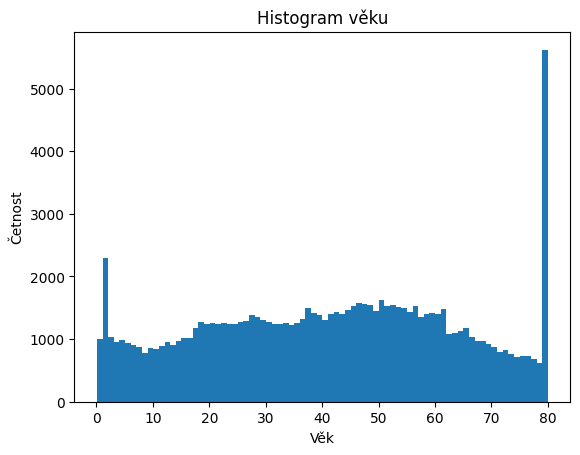

In [108]:
plt.hist(data['age'], bins=80)
plt.title("Histogram věku")
plt.xlabel("Věk")
plt.ylabel("Četnost")

In [109]:
import statistics
data['age_category'] = pd.cut(data['age'], bins=[0, 10, 20, 30, 40, 50, 60,70,80,], labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60','61-70','71-80'])
print(statistics.mode(data['age_category']))
statistics.mode(data['age'])


51-60


80.0

Njevíce je zastoupeno věkové rozmezí 51-60 let. 
Pro jeden konkrétní věk je to 80 let.

Text(0.5, 0, 'BMI')

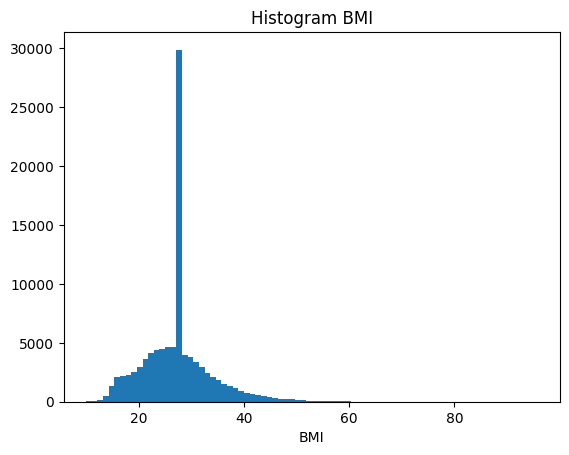

In [110]:
plt.hist(data['bmi'], bins=80)
plt.title("Histogram BMI")
plt.xlabel("BMI")


Text(0, 0.5, 'Četnost')

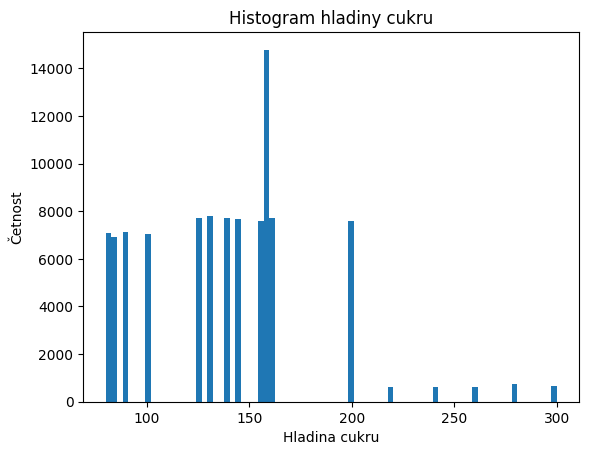

In [111]:
plt.hist(data['blood_glucose_level'], bins=80)
plt.title("Histogram hladiny cukru")
plt.xlabel("Hladina cukru")
plt.ylabel("Četnost")


#### Korelační grafy



Text(0, 0.5, 'Má diabetes')

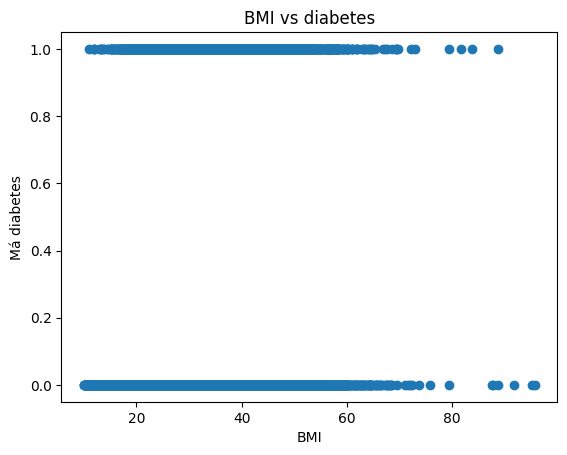

In [112]:
plt.scatter(data['bmi'],data['diabetes'])
plt.title("BMI vs diabetes")
plt.xlabel("BMI")
plt.ylabel("Má diabetes")


Text(0, 0.5, 'Má diabetes')

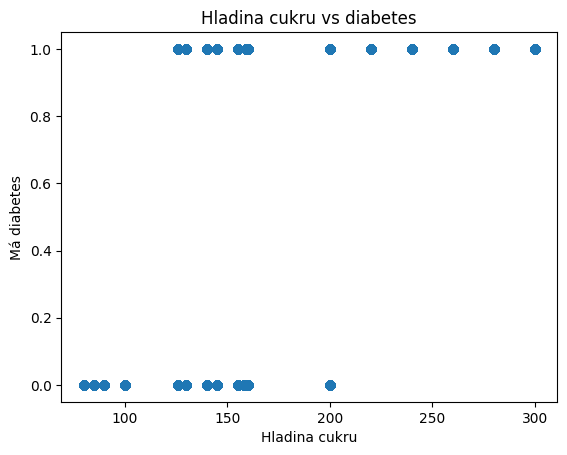

In [113]:
plt.scatter(data['blood_glucose_level'],data['diabetes'])
plt.title("Hladina cukru vs diabetes")
plt.xlabel("Hladina cukru")
plt.ylabel("Má diabetes")

Čím vyšší hladina cukru tím větší výskyt cukrovky


# Data preprocessing

## Preprocessing for supervised machine learning 

In [114]:
data = pd.read_csv("diabetes_prediction_dataset.csv")



### Derive binary target attribute (if not already binary)

Cílový atribut je již binární

#### Odstranění dat

Odstranění záznamů, kde je pohlaví určeno jako Other. Dataset obsahuje těchto instancí jen 16.

In [115]:
print ("Počet pro pohláví 'Other'",data[data['gender'] == 'Other'].shape[0])
data = data.drop(data[data['gender'] == 'Other'].index)

Počet pro pohláví 'Other' 18


### Train test split 

In [116]:
X = data.drop('diabetes', axis=1)
y = data['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set: ", X_train.shape)
print("Testing set: ", X_test.shape)

Training set:  (79985, 8)
Testing set:  (19997, 8)


### Feature engineering 

Do at least one additional data preprocessing, such as

-	Remove missing values
-	If the classes are imbalanced, you may upsample (or downsample) the training dataset.
-	Normalize values or use a standard scale 
-	Remove rows based on subsetting
-	Derive new columns
-	Perform feature selection (remove some attributes)


Make sure that your preprocessing operation does not use information from the test set. It is therefore recommended to “fit” preprocessing on the training set and then apply it on the test set.

#### Doplnění chybějících pozorování pro smoking_history

In [117]:
print(X_train['smoking_history'].value_counts())
print("celkem: " ,X_train['smoking_history'].shape[0])

smoking_history
No Info        28644
never          28030
former          7483
current         7472
not current     5139
ever            3217
Name: count, dtype: int64
celkem:  79985


In [118]:
value_counts = X_train[X_train['smoking_history'] != 'No Info']['smoking_history'].value_counts()
total_count = value_counts.sum()
distribution = (X_train['smoking_history'].value_counts() / total_count).drop('No Info')
random= np.random.choice(distribution.index,X_train[X_train['smoking_history'] == 'No Info'].shape[0] ,p=distribution.values)

X_train['smoking_history'].loc[X_train['smoking_history'] == 'No Info'] = random


C:\Users\filip\AppData\Local\Temp\ipykernel_13344\1581618481.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['smoking_history'].loc[X_train['smoking_history'] == 'No Info'] = random


In [119]:
print(X_train['smoking_history'].value_counts())
print("celkem: " ,X_train['smoking_history'].shape[0])

smoking_history
never          43767
current        11602
former         11596
not current     7978
ever            5042
Name: count, dtype: int64
celkem:  79985


In [120]:
#Jednodušší doplnění módusem
#X_train['smoking_history'] = X_train['smoking_history'].replace('No Info', str(X_train['smoking_history'].mode()[0]))
#X_train['smoking_history']

#### Upsampling

In [121]:
#První pokus upsamplingu

# X_train['diabetes'] = y_train
# X,y= X_train.drop('diabetes', axis=1), X_train['diabetes']
# X_up, y_up = resample(X[y==1], y[y==1], replace=True, n_samples=X[y==0].shape[0], random_state=42)
# X_resampled = pd.concat([X[y==0], X_up])
# y_resampled = pd.Series(np.concatenate([y[y==0], y_up]))
# print("Počet kde diabetes = 1 po upsamplingu: ", y_resampled.sum()) 

# X_train = X_resampled
# y_train = y_resampled

In [122]:
#Druhý pokus upsamplingu

# X_train['diabetes'] = y_train
# diabet_set = X_train[X_train['diabetes'] == 1]
# non_diabet_set = X_train[X_train['diabetes'] == 0]
# print("Počet kde diabetes = 1: ", diabet_set.shape[0])
# print("Počet kde diabetes = 0: ", non_diabet_set.shape[0])

# diabet_upsample = resample(diabet_set, replace=True, n_samples = len(non_diabet_set), random_state=42)

# print("Diabet class shape po upsamplingu:",diabet_upsample.shape)

# X_train = pd.concat([non_diabet_set, diabet_upsample])
# y_train = X_train['diabetes']
# X_train = X_train.drop('diabetes', axis=1)


#### Převedení kategoriálních hodnot na binární

##### Gender na binarní reprezentaci

In [123]:
X_train = pd.get_dummies(X_train, columns=['gender'])

X_train

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male
48062,14.0,0,0,current,27.32,4.8,200,False,True
38243,3.0,0,0,never,19.99,6.1,130,False,True
3806,51.0,0,0,never,27.32,7.0,130,False,True
63147,28.0,0,0,former,27.32,6.1,200,True,False
6006,10.0,0,0,never,17.70,6.6,100,False,True
...,...,...,...,...,...,...,...,...,...
6265,49.0,0,0,never,32.98,5.7,80,False,True
54896,58.0,0,0,not current,27.32,6.6,140,True,False
76838,42.0,0,0,never,27.32,6.6,140,False,True
860,37.0,0,0,never,24.96,6.2,158,True,False


##### Smoking_history na binární reprezentaci

In [124]:
X_train = pd.get_dummies(X_train, columns=['smoking_history'])

X_train

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
48062,14.0,0,0,27.32,4.8,200,False,True,True,False,False,False,False
38243,3.0,0,0,19.99,6.1,130,False,True,False,False,False,True,False
3806,51.0,0,0,27.32,7.0,130,False,True,False,False,False,True,False
63147,28.0,0,0,27.32,6.1,200,True,False,False,False,True,False,False
6006,10.0,0,0,17.70,6.6,100,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,49.0,0,0,32.98,5.7,80,False,True,False,False,False,True,False
54896,58.0,0,0,27.32,6.6,140,True,False,False,False,False,False,True
76838,42.0,0,0,27.32,6.6,140,False,True,False,False,False,True,False
860,37.0,0,0,24.96,6.2,158,True,False,False,False,False,True,False


#### Normalizace dat

In [125]:
X_train.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
count,79985.000000,79985.000000,79985.000000,79985.000000,79985.000000,79985.000000
mean,41.848169,0.075202,0.038895,27.310700,5.527780,137.992811
std,22.527146,0.263718,0.193345,6.642988,1.070549,40.686407
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000
25%,24.000000,0.000000,0.000000,23.600000,4.800000,100.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000
75%,60.000000,0.000000,0.000000,29.560000,6.200000,159.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000


In [126]:
scaler = MinMaxScaler()
X_train[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(X_train[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])
X_train.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
count,79985.000000,79985.000000,79985.000000,79985.000000,79985.000000,79985.000000
mean,0.522625,0.075202,0.038895,0.201922,0.368687,0.263604
std,0.281871,0.263718,0.193345,0.077533,0.194645,0.184938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.299299,0.000000,0.000000,0.158613,0.236364,0.090909
50%,0.537037,0.000000,0.000000,0.202031,0.418182,0.272727
75%,0.749750,0.000000,0.000000,0.228175,0.490909,0.359091
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [127]:
#Fuck it syntetický upsampling (todel fr nerding)

#definice pipeline
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train, y_train = pipeline.fit_resample(X_train,y_train)



In [128]:
y_train.value_counts()

diabetes
0    73260
1    36630
Name: count, dtype: int64

## Applying preprocessing on test data

In [129]:
value_counts = X_test[X_test['smoking_history'] != 'No Info']['smoking_history'].value_counts()
total_count = value_counts.sum()
distribution = (X_test['smoking_history'].value_counts() / total_count).drop('No Info')
random= np.random.choice(distribution.index,X_test[X_test['smoking_history'] == 'No Info'].shape[0] ,p=distribution.values)

X_test['smoking_history'].loc[X_test['smoking_history'] == 'No Info'] = random


X_test = pd.get_dummies(X_test, columns=['smoking_history'])
X_test = X_test.drop(X_test[X_test['gender'] == 'Other'].index)
X_test = pd.get_dummies(X_test, columns=['gender'])
X_test[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(X_test[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])

X_test.describe()

C:\Users\filip\AppData\Local\Temp\ipykernel_13344\2410801113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['smoking_history'].loc[X_test['smoking_history'] == 'No Info'] = random


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
count,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000,19997.000000
mean,0.525121,0.073511,0.041556,0.202409,0.368459,0.265081
std,0.281247,0.260980,0.199578,0.077718,0.194755,0.185462
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.299299,0.000000,0.000000,0.159732,0.236364,0.090909
50%,0.537037,0.000000,0.000000,0.201928,0.418182,0.272727
75%,0.749750,0.000000,0.000000,0.228961,0.490909,0.359091
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling

* Train the model on training data, and evaluate the model on test data. 
* Try at least two machine learning classification algorithms. It is recommended to try Decision Trees and Forests. 


### Classifier 1 (decision tree)

* Try various combinations of metaparameters (such as tree depth for decision tree) and record the impact on predictive performance. You can use grid search cross-validation for this.
* Once you determine the best values, you can refit the model with the best parameter value on the entire training data.

In [130]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}

dt_classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Nejlepši parametry",best_params)
print("Nejlepší skóre",best_score)

best_dt_classifier = DecisionTreeClassifier(**best_params)
best_dt_classifier.fit(X_train, y_train)


Nejlepši parametry {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Nejlepší skóre 0.922913822913823


DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)

### Classifier 2 (random forest)

* Try various combinations of metaparameters (such as  number of trees in a forest) and record the impact on predictive performance. You can use grid search cross-validation for this.
* Once you determine the best values, you can refit the model with the best parameter value on the entire training data.


In [131]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7, 10],
}

rf_classifier = RandomForestClassifier()

grid_search = GridSearchCV(rf_classifier, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Nejlepší parametry", best_params)
print("Nejlepší skóre", best_score)

best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(X_train, y_train)



Nejlepší parametry {'max_depth': 10, 'n_estimators': 100}
Nejlepší skóre 0.9262717262717264


RandomForestClassifier(max_depth=10)

### Classifier 3 (baseline)

* Fit a baseline model, e.g., a model that predicts the most frequent class in the training data

In [132]:
y_baseLinePred = np.zeros(y_test.shape[0])
y_baseLinePred

array([0., 0., 0., ..., 0., 0., 0.])

# Evaluation

### Classifier 1 (decision tree)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

#### Accuracy, precision, recall a F1 skóre

In [133]:
y_pred = best_dt_classifier.predict(X_test[X_train.columns])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.9184877731659749
Precision:  0.5257001063452676
Recall:  0.8354929577464789
F1 Score:  0.6453437771975631


#### ROC křivka a AUC skóre

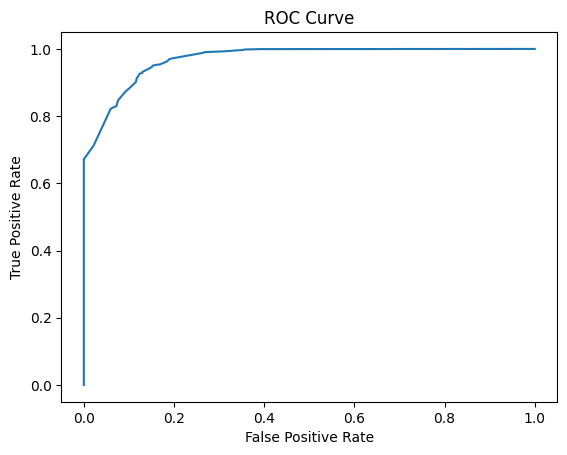

AUC Score:  0.9702930987306784


In [134]:
y_pred_proba = best_dt_classifier.predict_proba(X_test[X_train.columns])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score: ", auc_score)

#### Matice záměn (Confusion matrix)

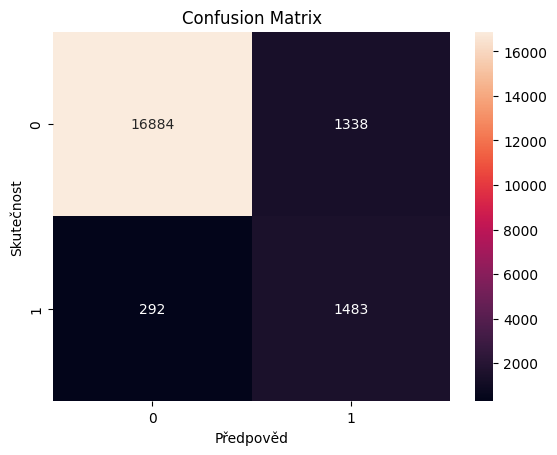

In [135]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Předpověd')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()

### Classifier 2 (random forest)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

#### Accuracy, precision, recall a F1 skóre

In [136]:
y_pred = best_rf_classifier.predict(X_test[X_train.columns])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.9595439315897385
Precision:  0.7719594594594594
Recall:  0.772394366197183
F1 Score:  0.7721768515911012


#### ROC křivka a AUC skóre

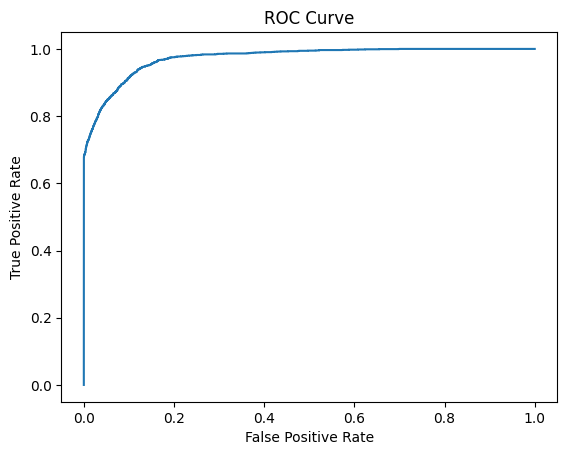

AUC Score:  0.9737579245641779


In [137]:
y_pred_proba = best_rf_classifier.predict_proba(X_test[X_train.columns])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score: ", auc_score)

#### Matice záměn (Confusion matrix)

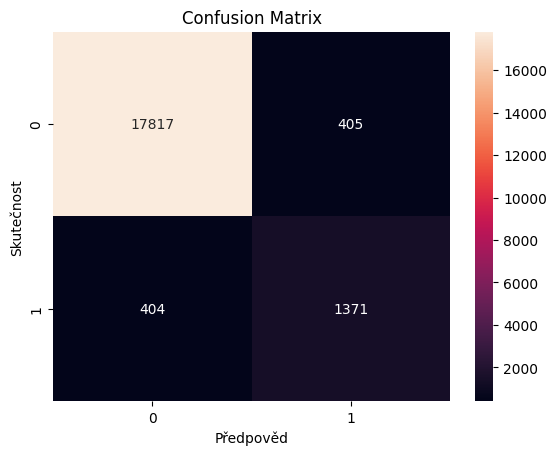

In [138]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Předpověd')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()

### Classifier 3 (baseline)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

#### Accuracy, precision, recall a F1 skóre

In [139]:
accuracy = accuracy_score(y_test, y_baseLinePred)
precision = precision_score(y_test, y_baseLinePred)
recall = recall_score(y_test, y_baseLinePred)
f1 = f1_score(y_test, y_baseLinePred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.9112366855028254
Precision:  0.0
Recall:  0.0
F1 Score:  0.0


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


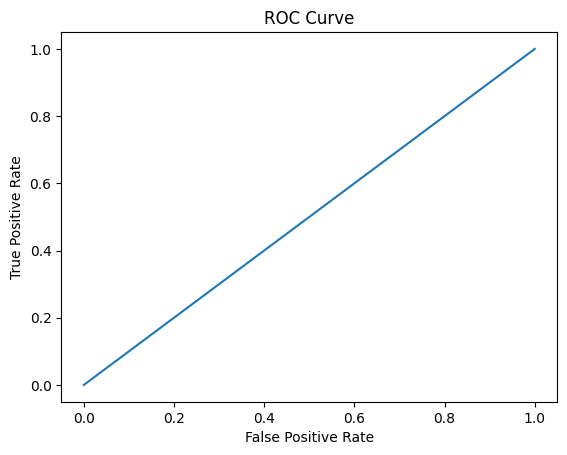

In [140]:
y_pred_proba = y_baseLinePred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Matice záměn (Confusion matrix)

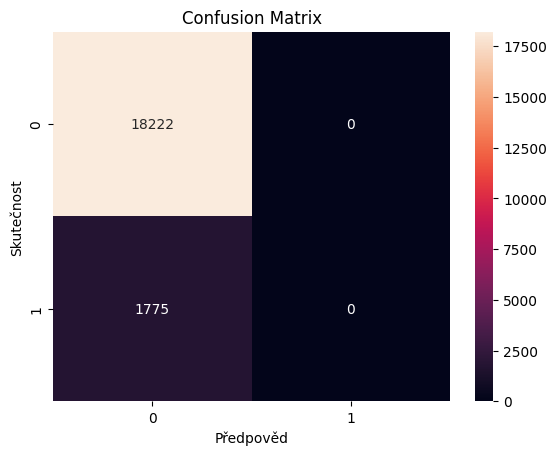

In [141]:
cm = confusion_matrix(y_test, y_baseLinePred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Předpověd')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()

### Summary

* Which metric is most suitable for use for the current problem (accuracy, F-measure)?
* Compare the performance metrics for all types of models (e.g,. decision tree and forest). Which model is the best one?
* Combine (multiply) the predefined costs matrix with the values in the confusion matrix for each model. Which model is the best one? 


# Explanation

## Global explanation

### Classifier 1 - decision tree

* Visualize the decision tree
* Looking at the tree, list the most important attributes

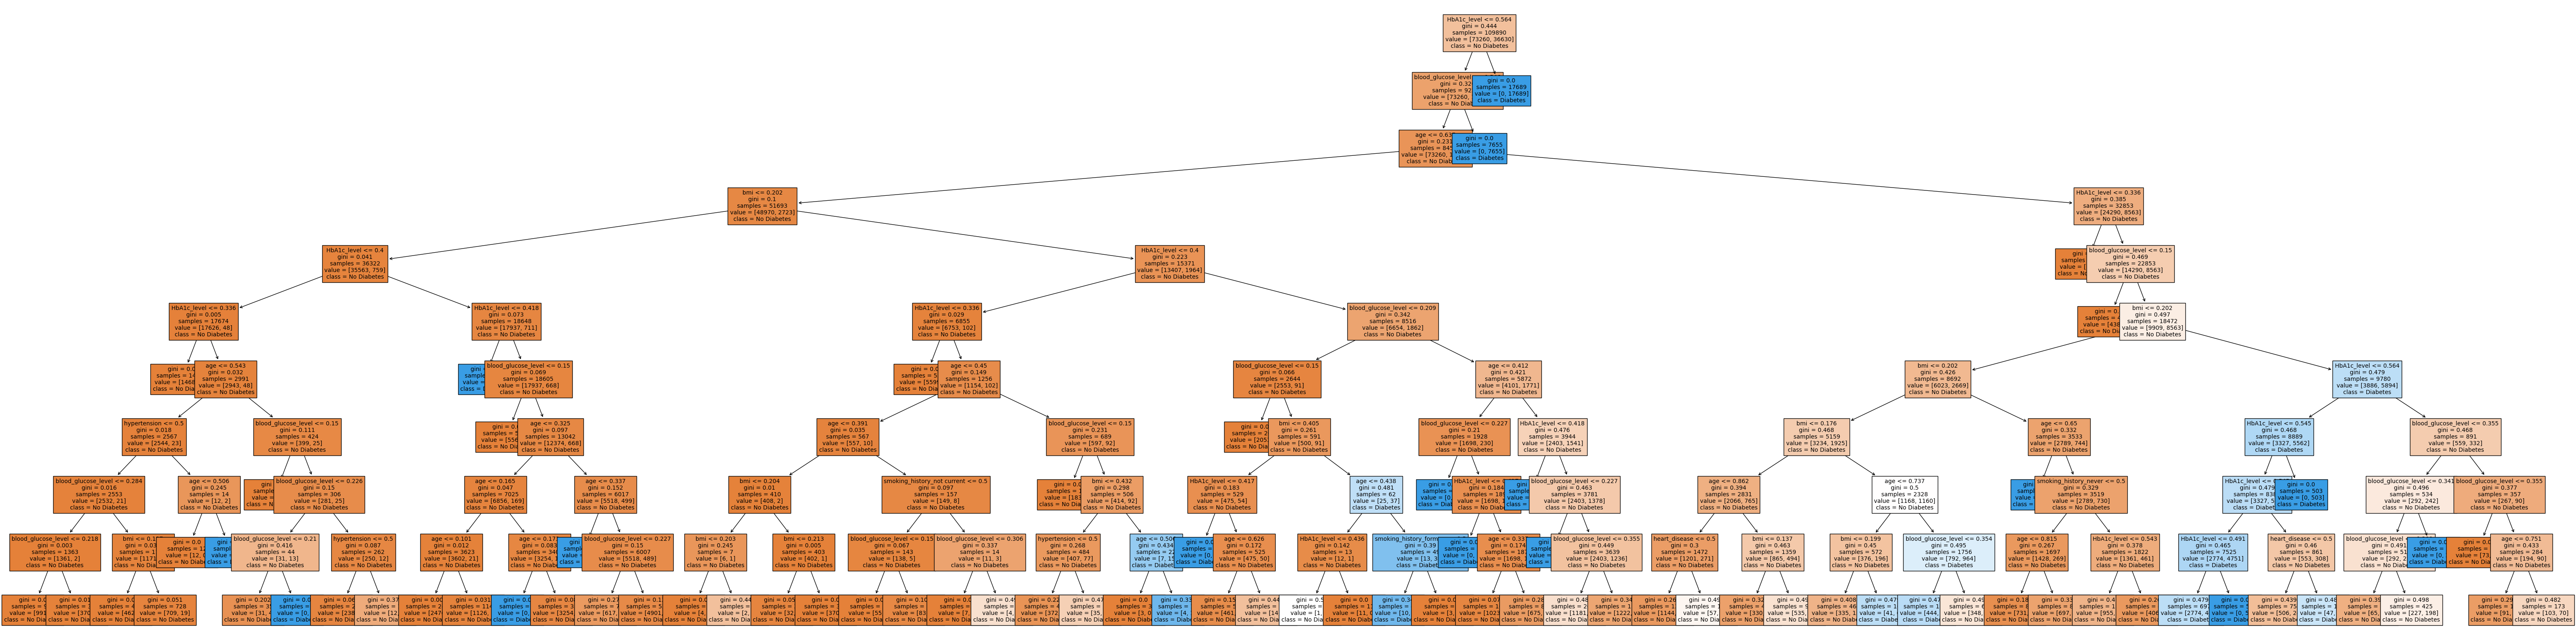

In [142]:
#visualize the decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(80,20))
plot_tree(best_dt_classifier, feature_names=X_train.columns, filled=True, fontsize=10,class_names=['No Diabetes', 'Diabetes'])
plt.show()

### Classifier 2 - random forest

* Show the feature importance of variables in the forest

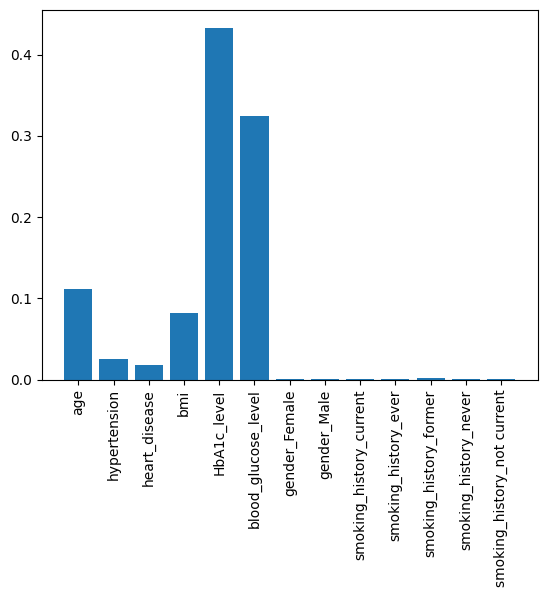

In [143]:
#show fratue importance for random forest
importance = best_rf_classifier.feature_importances_
plt.bar(X_train.columns, importance)
plt.xticks(rotation=90)
plt.show()

## Local explanation

* Show the *instance of interest* - a row in the dataframe
* Use both models to classify the chosen instance
* Do both models assign the same class?
* What is the confidence (probability) of the prediction?
* If you change the value of the attribute of interest in the instance of interest, how does the classification of the instance change? 

In [144]:
instance_of_interest = data[data['diabetes'] == 1]
instance_of_interest = instance_of_interest.iloc[35]
instance_of_interest = instance_of_interest[data.columns].values.reshape(1,-1)
instance_of_interest = pd.DataFrame(instance_of_interest, columns=data.columns)

print("Instance: \n",instance_of_interest)
instance_of_interest.drop('diabetes', axis=1,inplace = True)


instance_of_interest[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit(data[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]).transform(instance_of_interest[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])

instance_of_interest['gender_Female'] = 1
instance_of_interest['gender_Male'] = 0
instance_of_interest.drop('gender', axis=1, inplace=True)
instance_of_interest['smoking_history_never'] = 1
instance_of_interest['smoking_history_current'] = 0
instance_of_interest['smoking_history_former'] = 0
instance_of_interest['smoking_history_ever'] = 0
instance_of_interest['smoking_history_not current'] = 0
instance_of_interest.drop('smoking_history', axis=1, inplace=True)


decision_tree_output = best_dt_classifier.predict(instance_of_interest[X_train.columns])
random_forest_output = best_rf_classifier.predict(instance_of_interest[X_train.columns])

print("Decision Tree: ", decision_tree_output)
print("Random Forest: ", random_forest_output)


Instance: 
    gender   age hypertension heart_disease smoking_history    bmi HbA1c_level  \
0  Female  52.0            0             0         No Info  27.32         9.0   

  blood_glucose_level diabetes  
0                 140        1  
Decision Tree:  [1]
Random Forest:  [1]


# Conclusion
Summarize the results, answering questions such as:

1.	Which machine learning result has the highest value and is most interesting?

Nelepší výsledek vrací random forest. Precision je 77%. To znamená že pokud předpovíme že instance má diabet tak je naše předpověď ve 3/4 případech správná. Recall je 77%, to znamená že se nám v 1/4 správně předpovědět, že instance nemá diabet. Tento model nám vrací celkově nejlepší skóre ale jiné modely s celkovým skórem nižším na tom v tomto připadě můžou být lépe. V testech, kde se zjištujě přítomnost nějaké nemoci, je často v pořádku mít více false positives ale false negatives by se měly minimalizovat.


2.	What setting provided the best result? 

Jelikož dataset nebyl vyvážený a instancí kde byl diabet přítomen bylo velmi málo použili jsme upsampling. Když jsme použili upsampling typu zopakování isntancí kde byl diabet přítomen dostali jsme tuto matici:

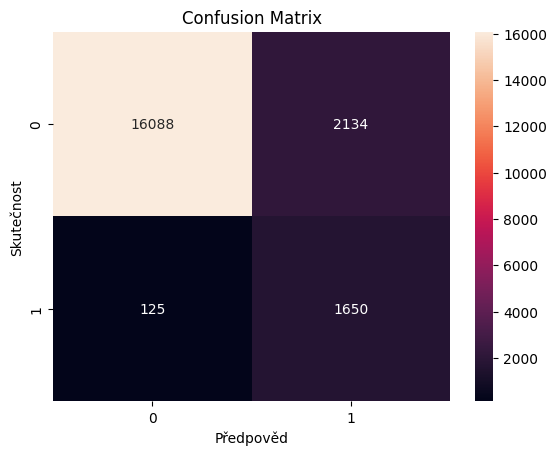

Na ní vidíme že celkové skóre modelu je horší než u nejlepšího modelu, ale false negative rate je lepší. Na nejlepší model byl použitý syntetický upsampling.

Paradoxně nejlepší výsledky měl ale model na který nebyl použitý upsampling vůbec. (v bodu jedna tento model uveden není)
Výsledky modelu bez upsamplingu vypadaly následovně:

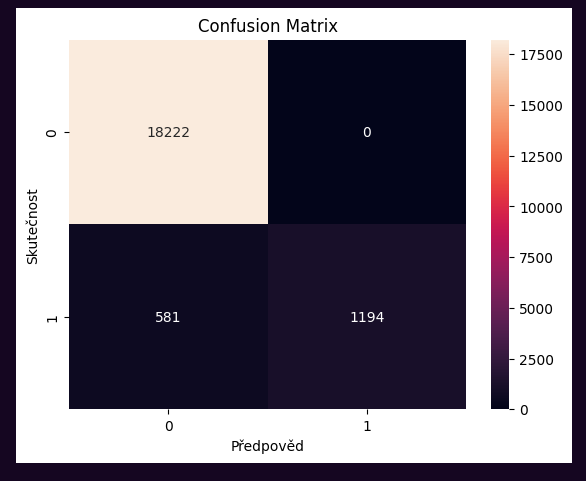

Přijde nám zvláštní, že bez použití upsamplingu, který je doporučený při řešení podobných problemů, jako je ten náš, dostáváme nejlepší výsledky.

3.	Which attributes are the most important?

Nejdůležitejšími atributy jsou blood glucose level a HbA1c level, což jsou oba ukazatele krevního cukru. Překvapivě atribut hisotire kouření byl modelem vyhodnocován jako zbytečný.


# Optional parts

## Evaluation 

## Ablation study
* Classification: Quantify the effect of individual preprocessing steps (such as rescaling). How would the performance change if you have not performed this step.
* Clustering: Try clustering with and without feature selection in the data preprocessing stage. Compare the results. What would be the impact on the result based on the Rand Index?

###  Optimization of threshold (optional)

* If you would change the probability (score) threshold for classification, would you obtain better results in terms of total costs? For which threshold? 

## Explanation

*	Apply ICE/IME/SHAPLEY/Anchors to explain the classification of the instance

# Final checklist

-	Are all preprocessing steps justified?
-	Did you try different metaparameter values where appropriate?
-	Are the results replicable? If you have the same data, does the report describe all steps in sufficient detail to obtain the same results as reported by the authors?
-	Were proper evaluation metrics selected? Are the results correctly interpreted?
-	Are all important steps explained and justified?
-	What is the quality of writing? Is the language clear and concise?


# Submission

* This .ipynb file with your code + its html version after the code was run (File-Save and export notebook as - html)
* Source data or a link to source data or source data being loaded from a url in the notebook
* Data files after preprorcessing (train.csv and test.csv)